## Import


In [15]:
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import matplotlib.pyplot as plt
import glob
import fiona
import geopandas as gpd
from dbfread import DBF
from pyproj import CRS
import shapefile  # pyshp
import os

os.makedirs("out", exist_ok=True)




## Climate Dataset


Tmax : 60 fichiers
Tmax CRS : EPSG:4326
Tmax bounds : BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)


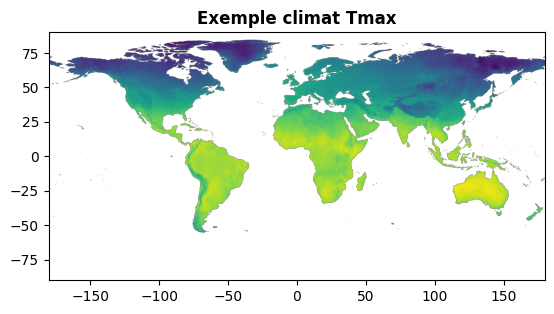

Tmin : 60 fichiers


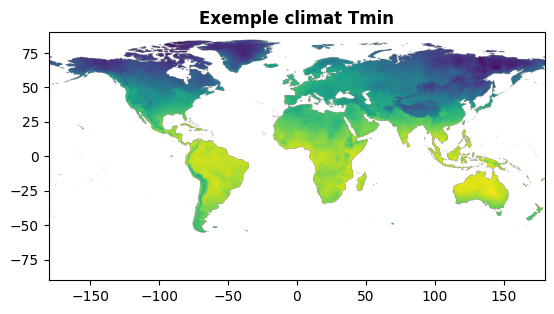

Prec : 60 fichiers


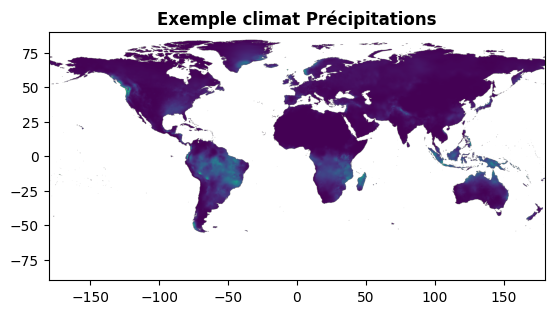

In [16]:
# Tmax
tmax_paths = sorted(glob.glob("../climate_dataset/5min/max/*.tif"))
print(f"Tmax : {len(tmax_paths)} fichiers")
with rasterio.open(tmax_paths[0]) as src:
    print("Tmax CRS :", src.crs)
    print("Tmax bounds :", src.bounds)
    show(src, title='Exemple climat Tmax')
    plt.show()

# Tmin
tmin_paths = sorted(glob.glob("../climate_dataset/5min/min/*.tif"))
print(f"Tmin : {len(tmin_paths)} fichiers")
with rasterio.open(tmin_paths[0]) as src:
    show(src, title='Exemple climat Tmin')
    plt.show()

# Précipitations
prec_paths = sorted(glob.glob("../climate_dataset/5min/prec/*.tif"))
print(f"Prec : {len(prec_paths)} fichiers")
with rasterio.open(prec_paths[0]) as src:
    show(src, title='Exemple climat Précipitations')
    plt.show()


## Elevation Dataset

✅ GeoDataFrame loaded
Columns: Index(['ID', 'geometry'], dtype='object')
CRS: EPSG:4326
                 ID                                           geometry
0  5e83a1f36d8572da  POLYGON ((180.01 -70, 180.01 -90, 180.00995 -9...

📄 .DBF attributes (from DBF file):
                 ID
0  5e83a1f36d8572da

🗺️  CRS (from PRJ file):
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]

📦 SHP details:
Number of shapes: 1
Fields: ['ID']
First record: Record #0: ['5e83a1f36d8572da']


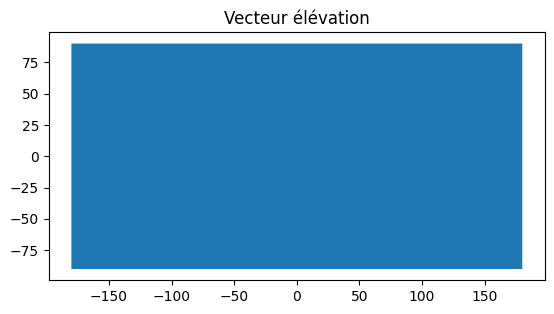

In [17]:
# === 1. Define the base name ===
base_path = "../elevation_dataset/gmted2010"

# === 2. Read geometry (and attributes) with GeoPandas ===
# GeoPandas reads .shp + .shx + .dbf + .prj automatically
elev_gdf = gpd.read_file(base_path + ".shp")

print("✅ GeoDataFrame loaded")
print("Columns:", elev_gdf.columns)
print("CRS:", elev_gdf.crs)
print(elev_gdf.head())

# === 3. (Optional) Read the .dbf manually to inspect attributes ===
table = DBF(base_path + ".dbf", load=True)
dbf_df = pd.DataFrame(iter(table))

print("\n📄 .DBF attributes (from DBF file):")
print(dbf_df.head())

# === 4. (Optional) Read the .prj manually to inspect projection ===
with open(base_path + ".prj", "r") as prj_file:
    prj_text = prj_file.read()
crs = CRS.from_wkt(prj_text)

print("\n🗺️  CRS (from PRJ file):")
print(crs)

# === 5. (Optional) Read the shapefile manually using pyshp ===
sf = shapefile.Reader(base_path + ".shp")
shapes = sf.shapes()
records = sf.records()
fields = [f[0] for f in sf.fields[1:]]  # skip deletion flag

print("\n📦 SHP details:")
print("Number of shapes:", len(shapes))
print("Fields:", fields)
print("First record:", records[0])

# === 6. Plot the geometry ===
elev_gdf.plot()
plt.title("Vecteur élévation")
plt.show()

## Land Dataset

In [18]:


# Load shapefile
landcover_dz = gpd.read_file("../land_dataset/algeria/dza_gc_adg.shp")
print("Landcover Algérie - Colonnes :", landcover_dz.columns)
display(landcover_dz.head())




Landcover Algérie - Colonnes : Index(['ID', 'GRIDCODE', 'AREA', 'LCCCODE', 'geometry'], dtype='object')


,ID,GRIDCODE,AREA,LCCCODE,geometry
0,4,210,6.228187e+06,7001 // 8001,"POLYGON ((6.41528 37.08696, 6.43103 37.0855, 6..."
1,2,210,6.242408e+06,7001 // 8001,"POLYGON ((7.18084 37.07917, 7.17998 37.08091, ..."
2,1,210,1.482995e+06,7001 // 8001,"POLYGON ((7.37137 37.08194, 7.3709 37.08717, 7..."
3,8,50,4.590841e+08,21497-121340,"POLYGON ((6.12361 36.68472, 6.12361 36.69306, ..."
4,13,210,6.371533e+06,7001 // 8001,"POLYGON ((6.26181 37.02361, 6.26193 37.02514, ..."


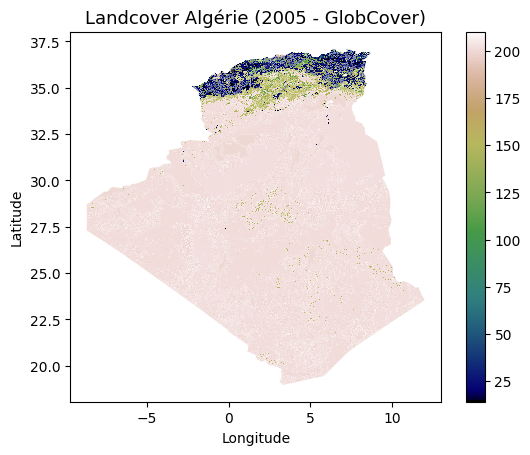

In [19]:
# Plot with colors based on land cover code
fig, ax = plt.subplots()

landcover_dz.plot(column='GRIDCODE', cmap='gist_earth', legend=True,ax=ax)



ax.set_title("Landcover Algérie (2005 - GlobCover)", fontsize=13)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

## Fire Dataset

### Algeria

In [20]:
fire_dz = pd.read_csv("../fire_dataset/viirs-jpss1_2024_Algeria.csv")
display(fire_dz.head())

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,type
0,27.72818,9.87200,295.51,0.76,0.77,2024-01-01,3,N20,VIIRS,n,2,277.66,1.24,N,2
1,28.63288,9.77909,301.80,0.79,0.78,2024-01-01,3,N20,VIIRS,n,2,277.05,1.57,N,2
2,28.64012,9.77953,298.65,0.79,0.78,2024-01-01,3,N20,VIIRS,n,2,277.04,1.34,N,2
3,36.74886,6.25409,338.04,0.46,0.39,2024-01-01,141,N20,VIIRS,n,2,257.28,5.21,N,2
4,35.87978,4.44782,309.49,0.41,0.37,2024-01-01,141,N20,VIIRS,n,2,272.08,1.58,N,2


### Tunisia

In [21]:
fire_tn = pd.read_csv("../fire_dataset/viirs-jpss1_2024_Tunisia.csv")
display(fire_tn.head())

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,type
0,31.64847,9.16945,315.79,0.53,0.50,2024-01-01,142,N20,VIIRS,n,2,279.09,2.20,N,2
1,31.49290,9.48947,302.32,0.56,0.51,2024-01-01,142,N20,VIIRS,n,2,276.10,1.23,N,0
2,31.49524,9.49053,301.88,0.56,0.51,2024-01-01,142,N20,VIIRS,n,2,276.12,0.77,N,0
3,33.36728,8.54768,302.58,0.45,0.47,2024-01-01,142,N20,VIIRS,n,2,277.15,0.80,N,2
4,31.64812,9.17107,320.80,0.46,0.39,2024-01-02,124,N20,VIIRS,n,2,278.37,2.44,N,2


## ShapeFiles

### Algeria

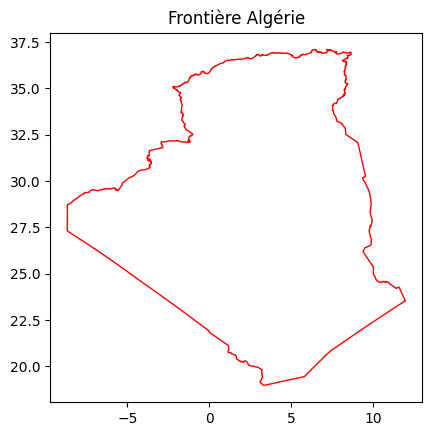

In [22]:
algeria_poly = gpd.read_file("../shapefiles/algeria/gadm41_DZA_0.shp")
algeria_poly.plot(edgecolor='red', facecolor='none')
plt.title("Frontière Algérie")
plt.show()


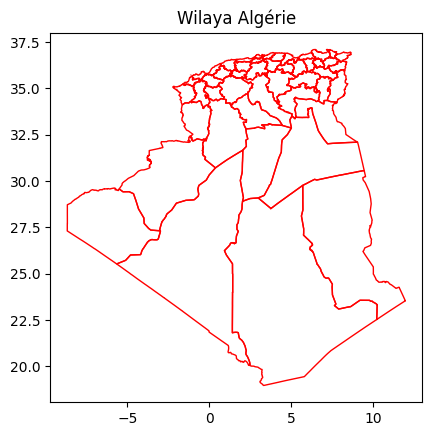

In [23]:
algeria_poly = gpd.read_file("../shapefiles/algeria/gadm41_DZA_1.shp")
algeria_poly.plot(edgecolor='red', facecolor='none')
plt.title("Wilaya Algérie")
plt.show()

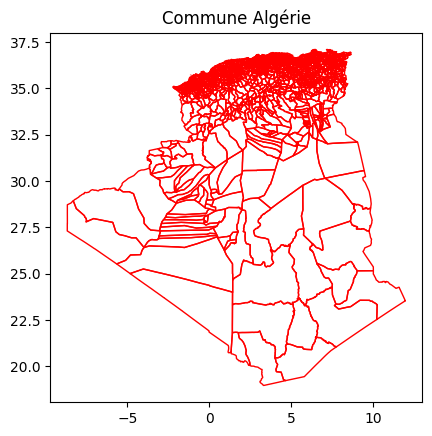

In [24]:
algeria_poly = gpd.read_file("../shapefiles/algeria/gadm41_DZA_2.shp")
algeria_poly.plot(edgecolor='red', facecolor='none')
plt.title("Commune Algérie")
plt.show()

### Tunisia

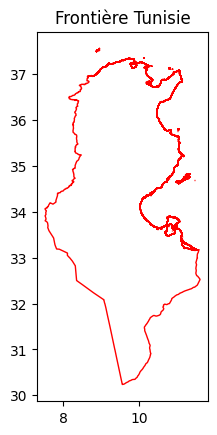

In [25]:
algeria_poly = gpd.read_file("../shapefiles/tunisia/gadm41_TUN_0.shp")
algeria_poly.plot(edgecolor='red', facecolor='none')
plt.title("Frontière Tunisie")
plt.show()


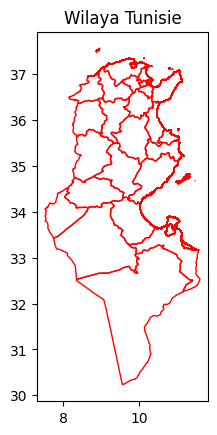

In [26]:
algeria_poly = gpd.read_file("../shapefiles/tunisia/gadm41_TUN_1.shp")
algeria_poly.plot(edgecolor='red', facecolor='none')
plt.title("Wilaya Tunisie")
plt.show()

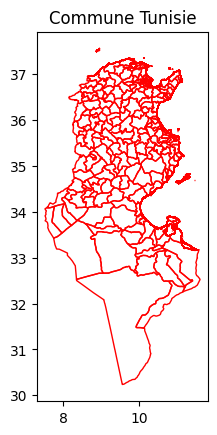

In [27]:
algeria_poly = gpd.read_file("../shapefiles/tunisia/gadm41_TUN_2.shp")
algeria_poly.plot(edgecolor='red', facecolor='none')
plt.title("Commune Tunisie")
plt.show()

## Worldwide Clip 

In [28]:
def clip_raster_to_shape(raster_path, shape_path, output_path):
    with fiona.open(shape_path) as shape:
        geoms = [feature["geometry"] for feature in shape]
    with rasterio.open(raster_path) as src:
        out_image, out_transform = mask(src, geoms, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)
    print(f"Raster clipped and saved to {output_path}")


In [29]:
# Algérie
clip_raster_to_shape("../climate_dataset/5min/max/wc2.1_cruts4.09_5m_tmax_2020-01.tif",
                     "../shapefiles/algeria/gadm41_DZA_0.shp",
                     "out/tmax_2020-01_clip_dza.tif")

# Tunisie
clip_raster_to_shape("../climate_dataset/5min/max/wc2.1_cruts4.09_5m_tmax_2020-01.tif",
                     "../shapefiles/tunisia/gadm41_TUN_0.shp",
                     "out/tmax_2020-01_clip_tun.tif")


Raster clipped and saved to out/tmax_2020-01_clip_dza.tif
Raster clipped and saved to out/tmax_2020-01_clip_tun.tif


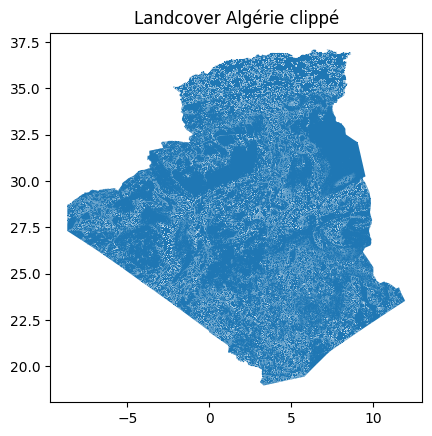

In [30]:


# Algérie : clip landcover
algeria_poly = gpd.read_file("../shapefiles/algeria/gadm41_DZA_0.shp")
landcover = gpd.read_file("../land_dataset/algeria/dza_gc_adg.shp")
landcover_clip = gpd.clip(landcover, algeria_poly)
landcover_clip.plot()
plt.title("Landcover Algérie clippé")
plt.show()




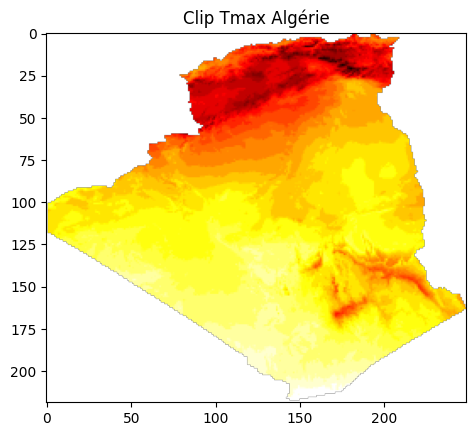

In [31]:
with fiona.open("../shapefiles/algeria/gadm41_DZA_0.shp") as shape:
    geoms = [feature["geometry"] for feature in shape]

with rasterio.open(tmax_paths[0]) as src:
    out_image, out_transform = rasterio.mask.mask(src, geoms, crop=True)
    plt.imshow(out_image[0], cmap='hot')
    plt.title('Clip Tmax Algérie')
    plt.show()


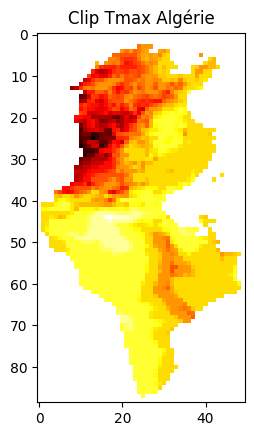

In [32]:
import fiona , rasterio
with fiona.open("../shapefiles/tunisia/gadm41_TUN_0.shp") as shape:
    geoms = [feature["geometry"] for feature in shape]

with rasterio.open(tmax_paths[0]) as src:
    out_image, out_transform = rasterio.mask.mask(src, geoms, crop=True)
    plt.imshow(out_image[0], cmap='hot')
    plt.title('Clip Tmax Algérie')
    plt.show()
